In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt

In [10]:
np.random.seed(2)
T = 20
L = 1000
N = 100

x = np.empty((N,L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
x

array([[ -65,  -64,  -63, ...,  932,  933,  934],
       [  -8,   -7,   -6, ...,  989,  990,  991],
       [ -58,  -57,  -56, ...,  939,  940,  941],
       ..., 
       [  -5,   -4,   -3, ...,  992,  993,  994],
       [  30,   31,   32, ..., 1027, 1028, 1029],
       [ -30,  -29,  -28, ...,  967,  968,  969]])

In [19]:
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [12]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru1 = nn.GRUCell(self.input_size, self.hidden_size)
        self.gru2 = nn.GRUCell(self.hidden_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.input_size)
    
    def forward(self, input, future=0):
        outputs = []
        hidden_t1 = Variable(torch.zeros(input.size(0), self.hidden_size).double(), requires_grad=False)
        hidden_t2 = Variable(torch.zeros(input.size(0), self.hidden_size).double(), requires_grad=False)
        
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            hidden_t1 = self.gru1(input_t, hidden_t1)
            hidden_t2 = self.gru2(hidden_t1, hidden_t2)
            output = self.linear(hidden_t2)
            outputs += [output]
            
        for i in range(future):
            hidden_t1 = self.gru1(input_t, hidden_t1)
            hidden_t2 = self.gru2(hidden_t1, hidden_t2)
            output = self.linear(hidden_t2)
            outputs += [output]
            
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs
        

In [32]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTMCell(self.input_size, self.hidden_size)
        self.lstm2 = nn.LSTMCell(self.hidden_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.input_size)
    
    def forward(self, input, future=0):
        outputs = []
        hidden_t1 = Variable(torch.zeros(input.size(0), self.hidden_size).double(), 
                             requires_grad=False)
        cell_t1 = Variable(torch.zeros(input.size(0), self.hidden_size).double(), 
                           requires_grad=False)
        hidden_t2 = Variable(torch.zeros(input.size(0), self.hidden_size).double(), 
                             requires_grad=False)
        cell_t2 = Variable(torch.zeros(input.size(0), self.hidden_size).double(), 
                           requires_grad=False)
        
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            hidden_t1, cell_t1 = self.lstm1(input_t, (hidden_t1, cell_t1))
            hidden_t2, cell_t2 = self.lstm2(hidden_t1, (hidden_t2, cell_t2))
            output = self.linear(hidden_t2)
            outputs += [output]
            
        for i in range(future):
            hidden_t1, cell_t1 = self.lstm1(output, (hidden_t1, cell_t1))
            hidden_t2, cell_t2 = self.lstm2(hidden_t1, (hidden_t2, cell_t2))
            output = self.linear(hidden_t2)
            outputs += [output]
            
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs
        

In [33]:
np.random.seed(0)
torch.manual_seed(0)

data = torch.load('traindata.pt')
input = Variable(torch.from_numpy(data[3:, :-1]), requires_grad=False)
target = Variable(torch.from_numpy(data[3:, 1:]), requires_grad=False)
test_input = Variable(torch.from_numpy(data[:3, :-1]), requires_grad=False)
test_target = Variable(torch.from_numpy(data[:3, 1:]), requires_grad=False)

In [37]:
def draw_results(input, y, future, i):
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.savefig('predict%d.pdf'%i)


In [38]:
def train():

    for i in range(10):
        print('STEP: ', i)
        def train_step():
            optimizer.zero_grad()
            out = model(input)
            loss = criterion(out, target)
            print('loss: ', loss.data.numpy()[0])
            loss.backward()
            return loss
        optimizer.step(train_step)

        # predictions
        future = 1000
        pred = model(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss: ', loss.data.numpy()[0])

        y = pred.data.numpy()

        draw_results(input, y, future,  i)

STEP:  0
loss:  0.562856241611
loss:  0.532737899701
loss:  0.505308532423
loss:  0.498354680548
loss:  0.48409303404
loss:  0.44643826614
loss:  0.075654728772
loss:  13088.2507154
loss:  504.075555158
loss:  46.7049925831
loss:  1.58889998244
loss:  0.149192991446
loss:  0.0619748043083
loss:  0.0428203049519
loss:  0.0405321153394
loss:  0.0382707472136
loss:  0.0335592238146
loss:  0.0261051406828
loss:  0.0165381227061
loss:  0.0365004446479
test loss:  0.0102827113618
STEP:  1
loss:  0.0106003580052
loss:  0.0078784342454
loss:  0.00558752420986
loss:  0.00301252221132
loss:  0.00234009516197
loss:  0.00200869765339
loss:  0.0015438213008
loss:  0.00109260951627
loss:  0.000922287301913
loss:  0.000888774171288
loss:  0.000876791853855
loss:  0.000854141133509
loss:  0.000774445471391
loss:  0.000588655851413
loss:  0.000414840156295
loss:  0.000496348551673
loss:  0.000253308999065
loss:  0.000225056825924
loss:  0.000215860273282
loss:  0.000209829607256
test loss:  0.000131285

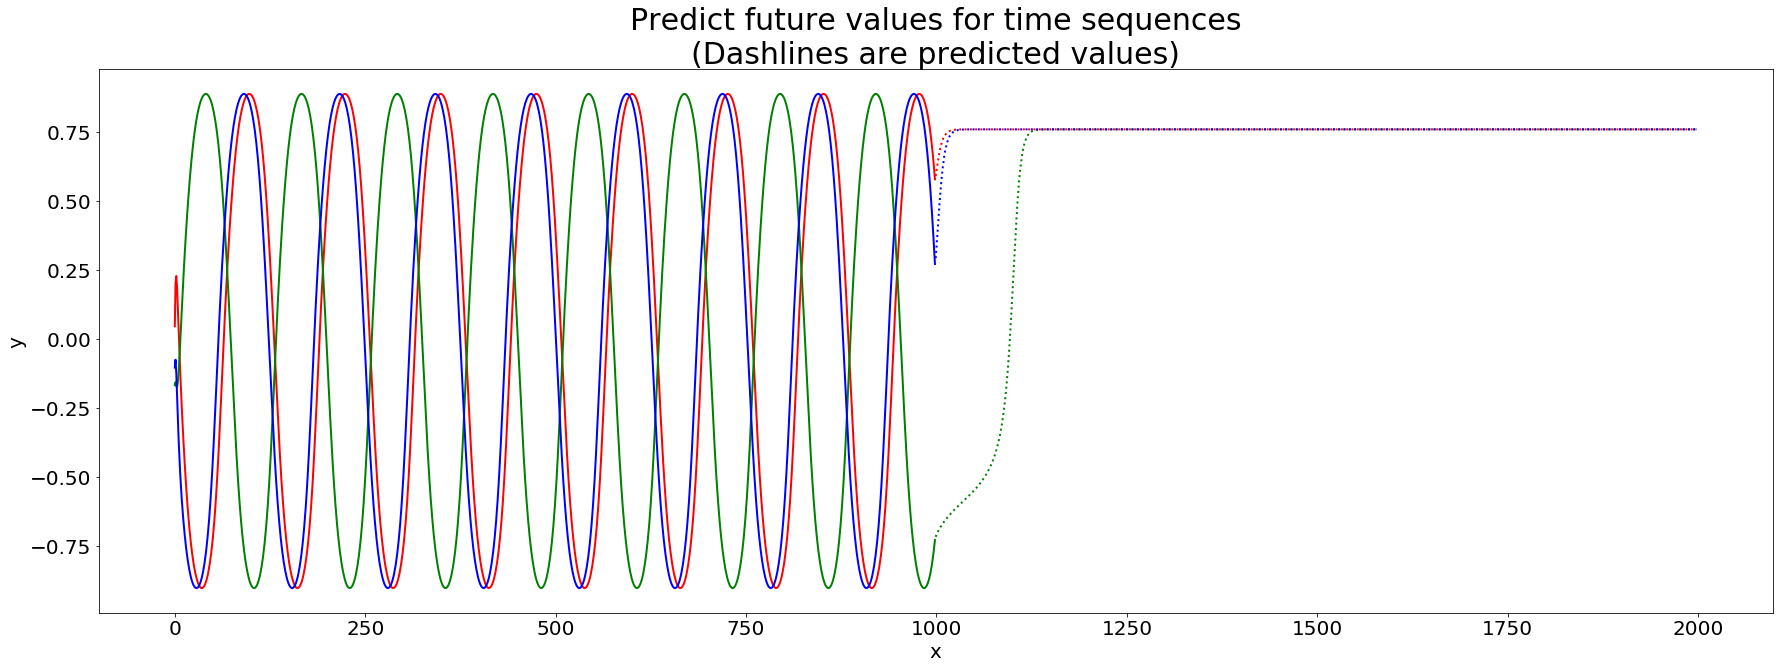

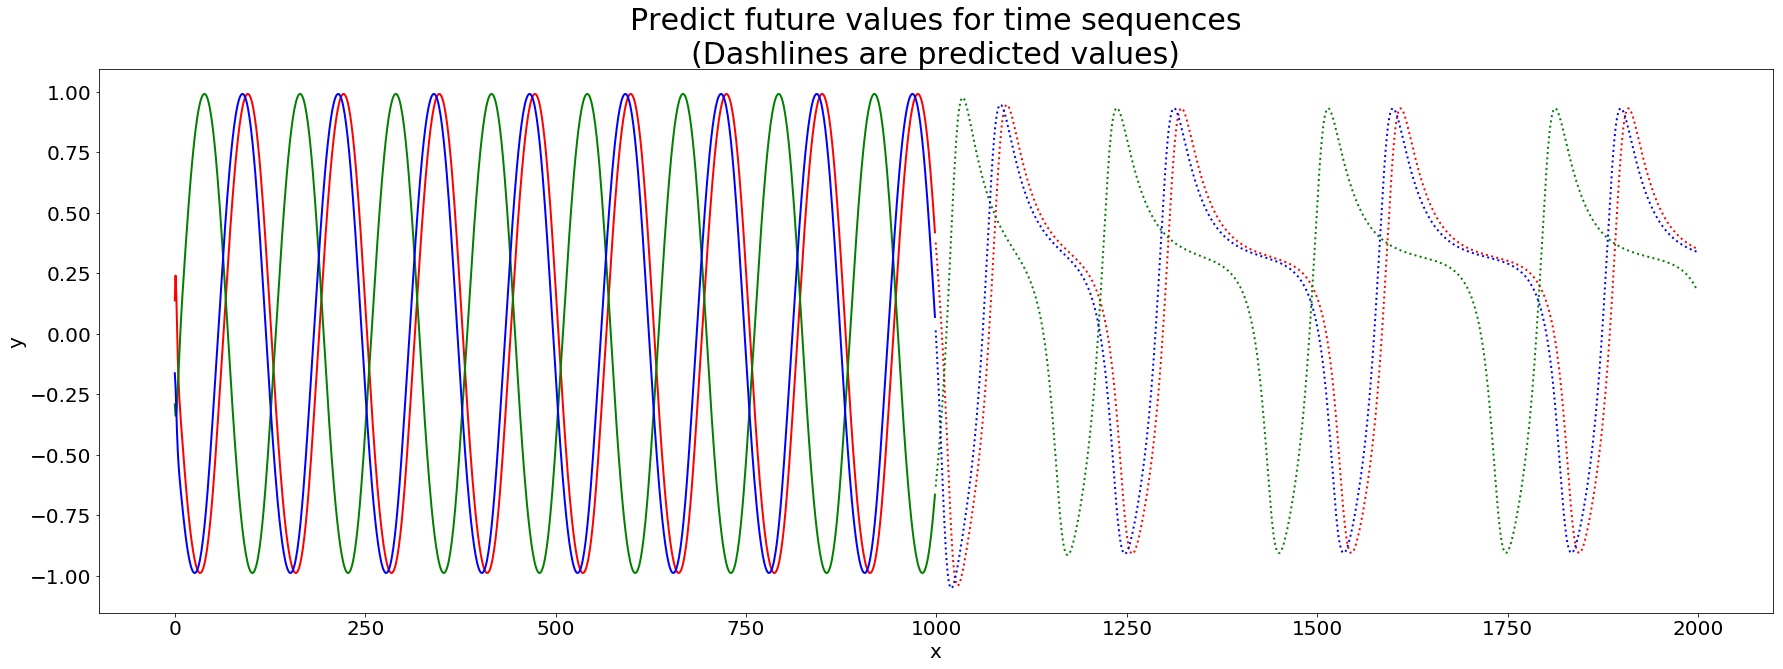

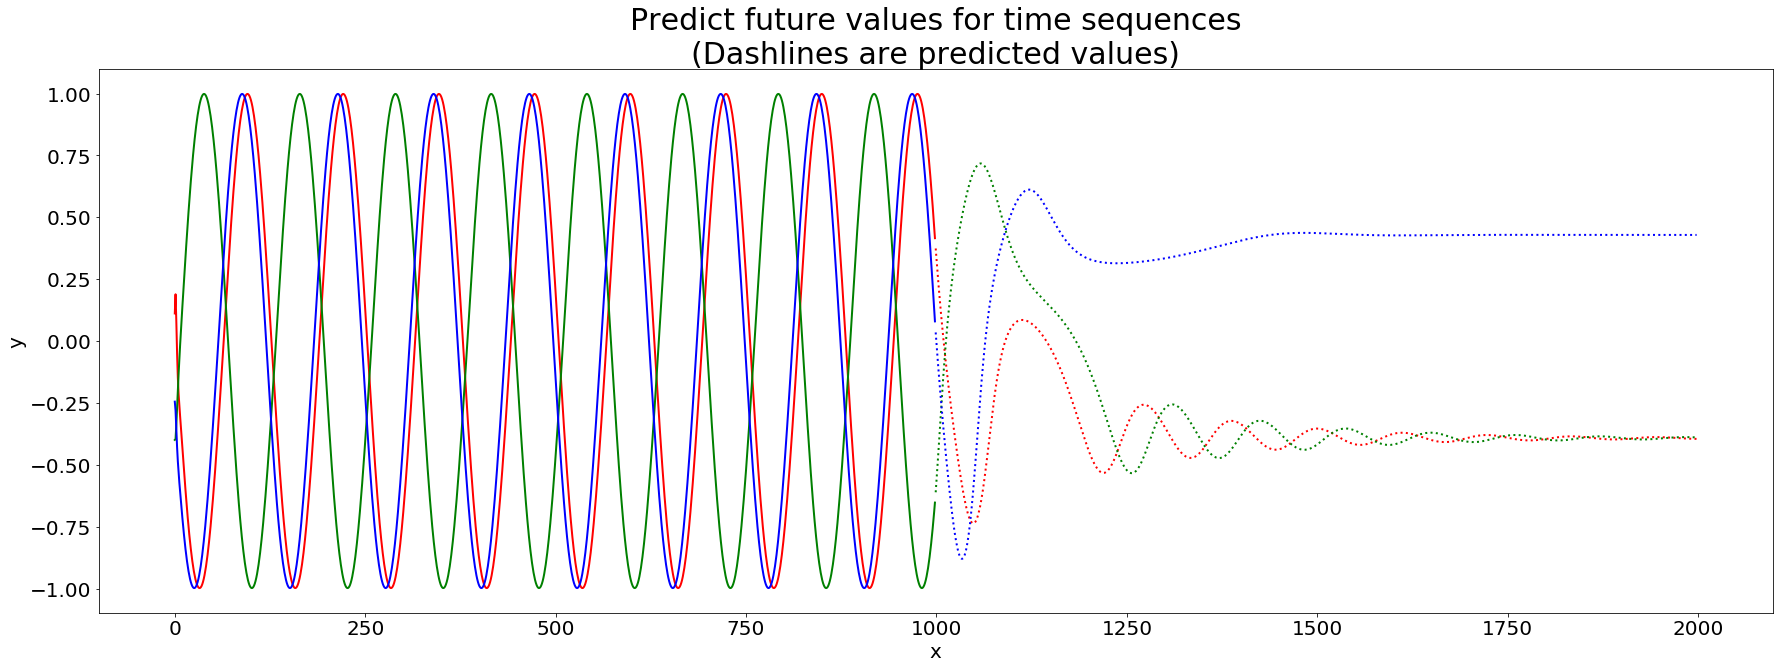

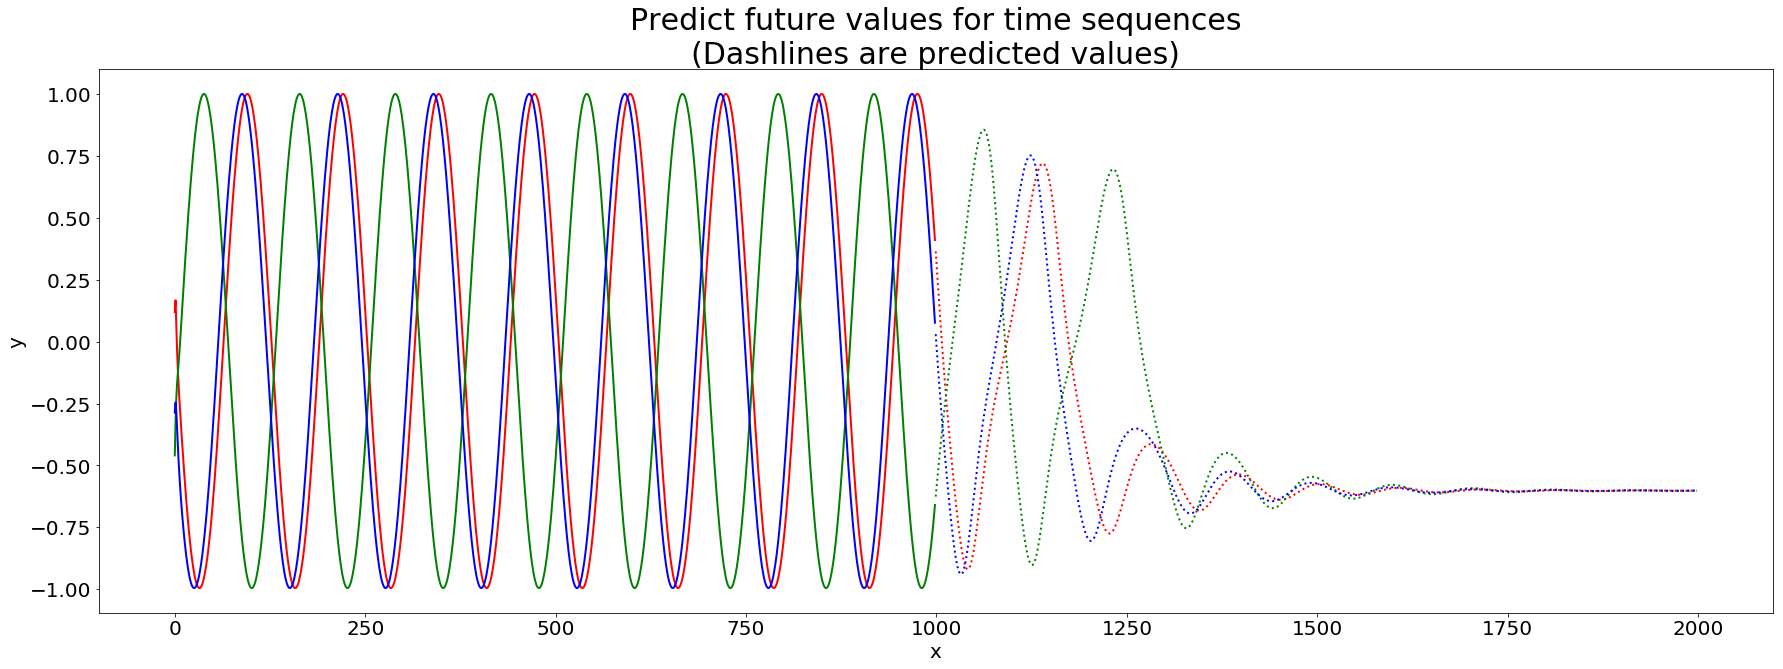

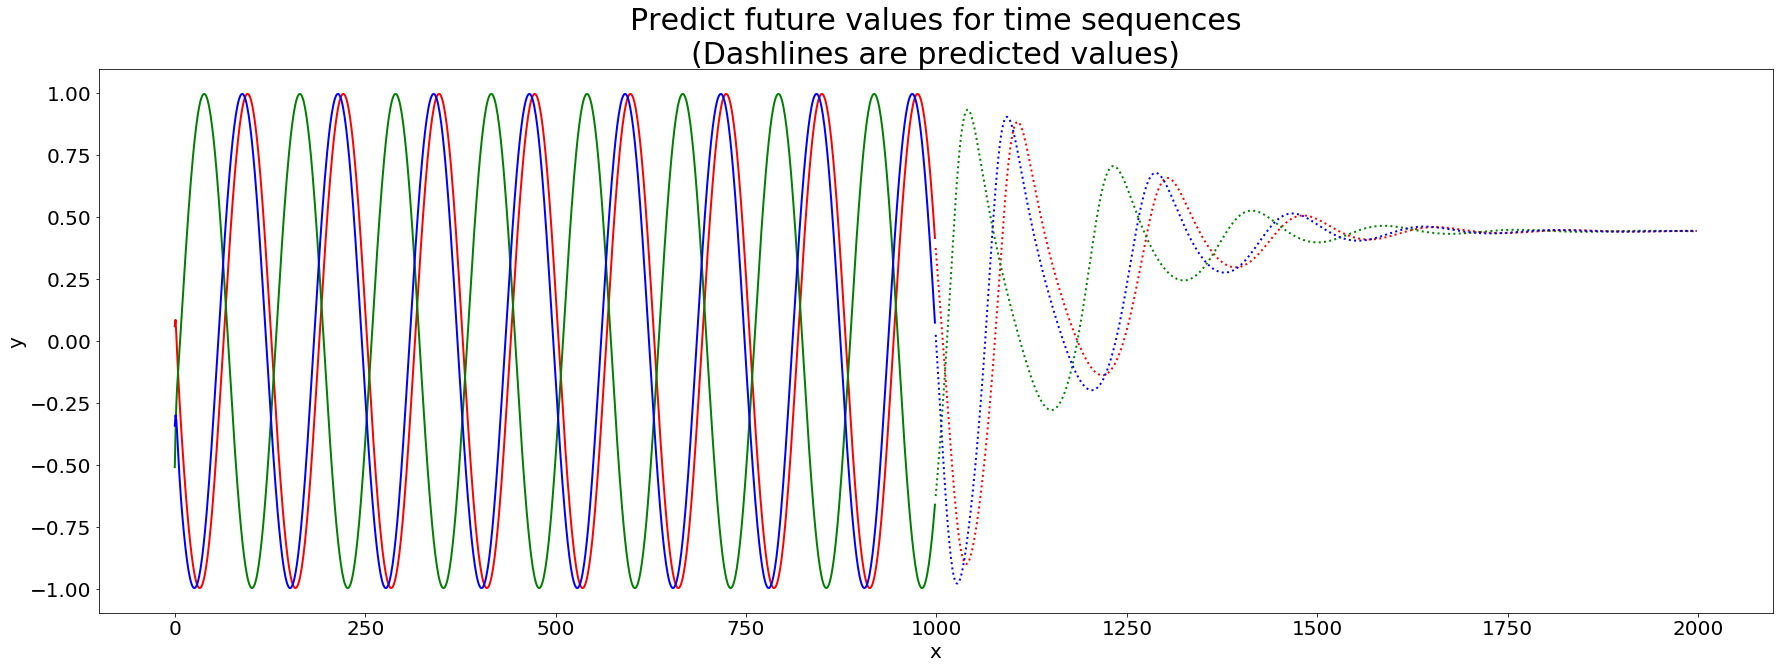

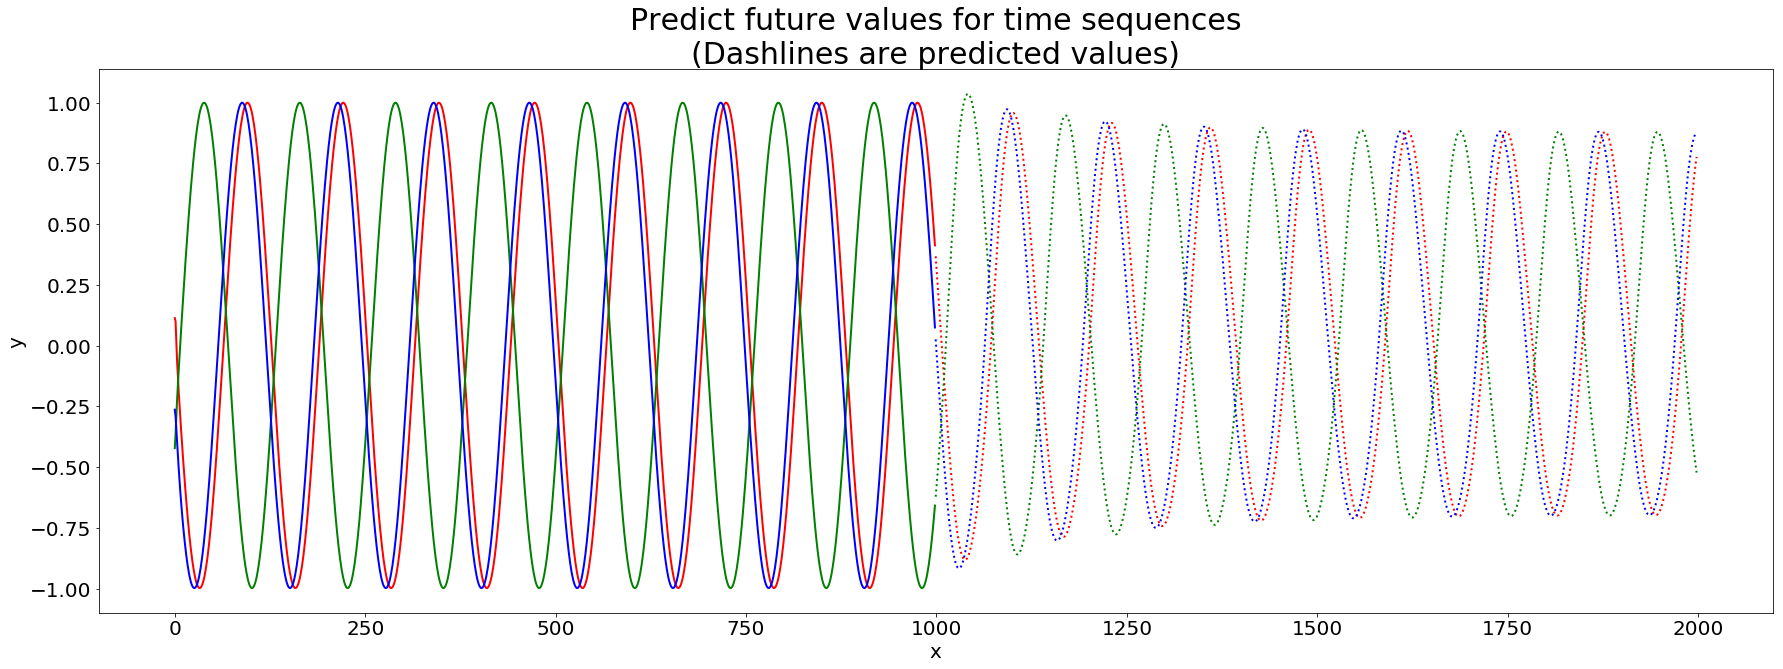

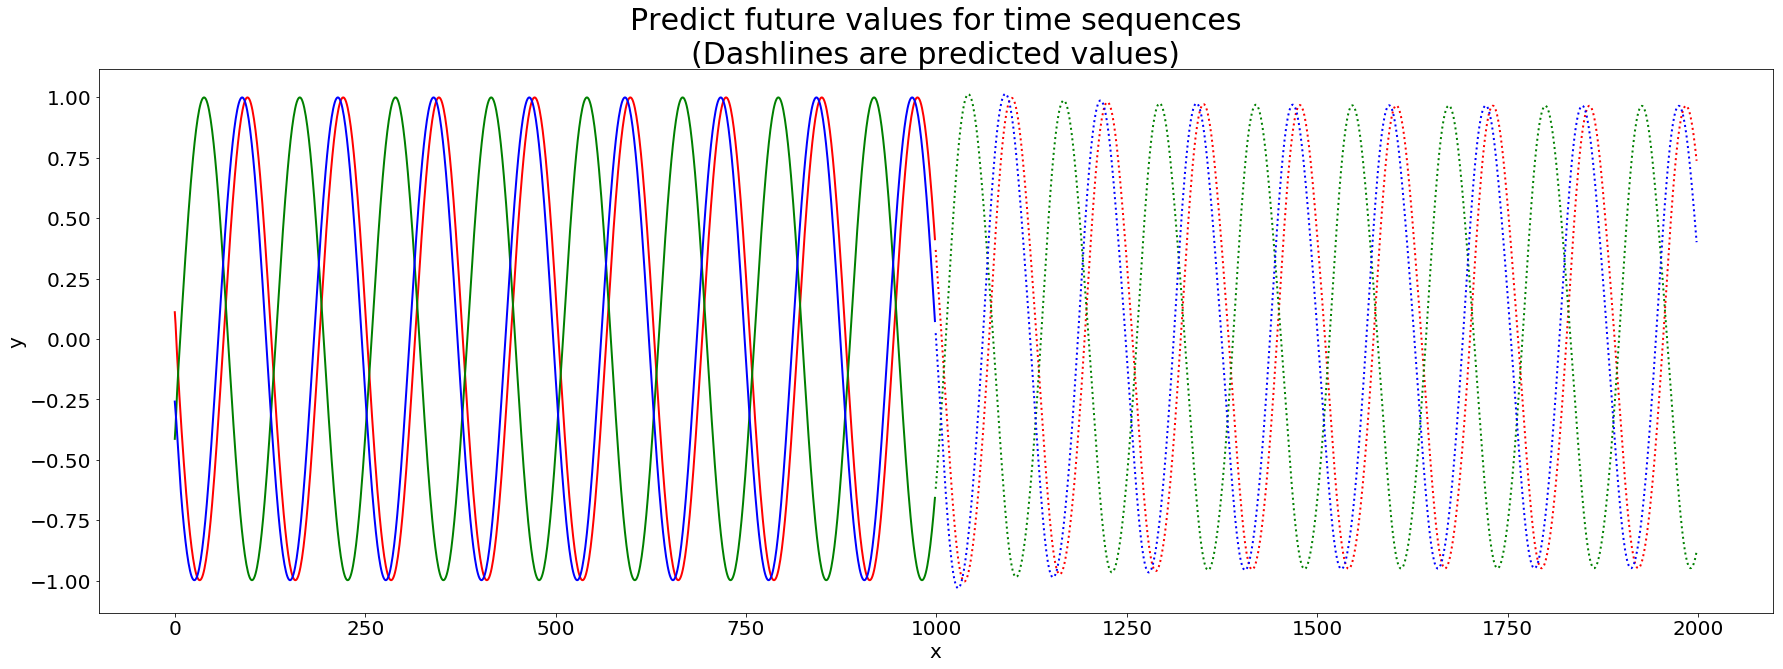

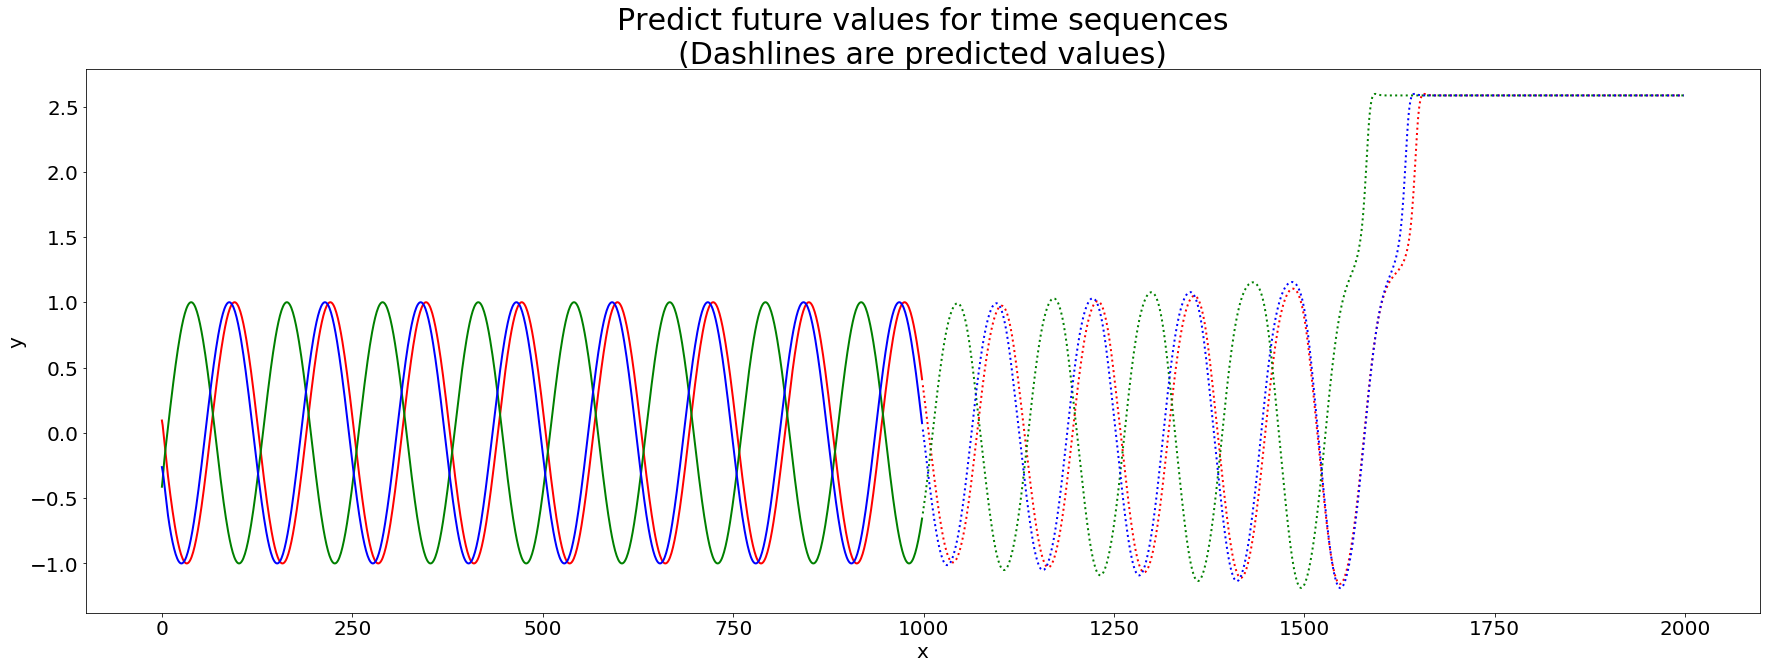

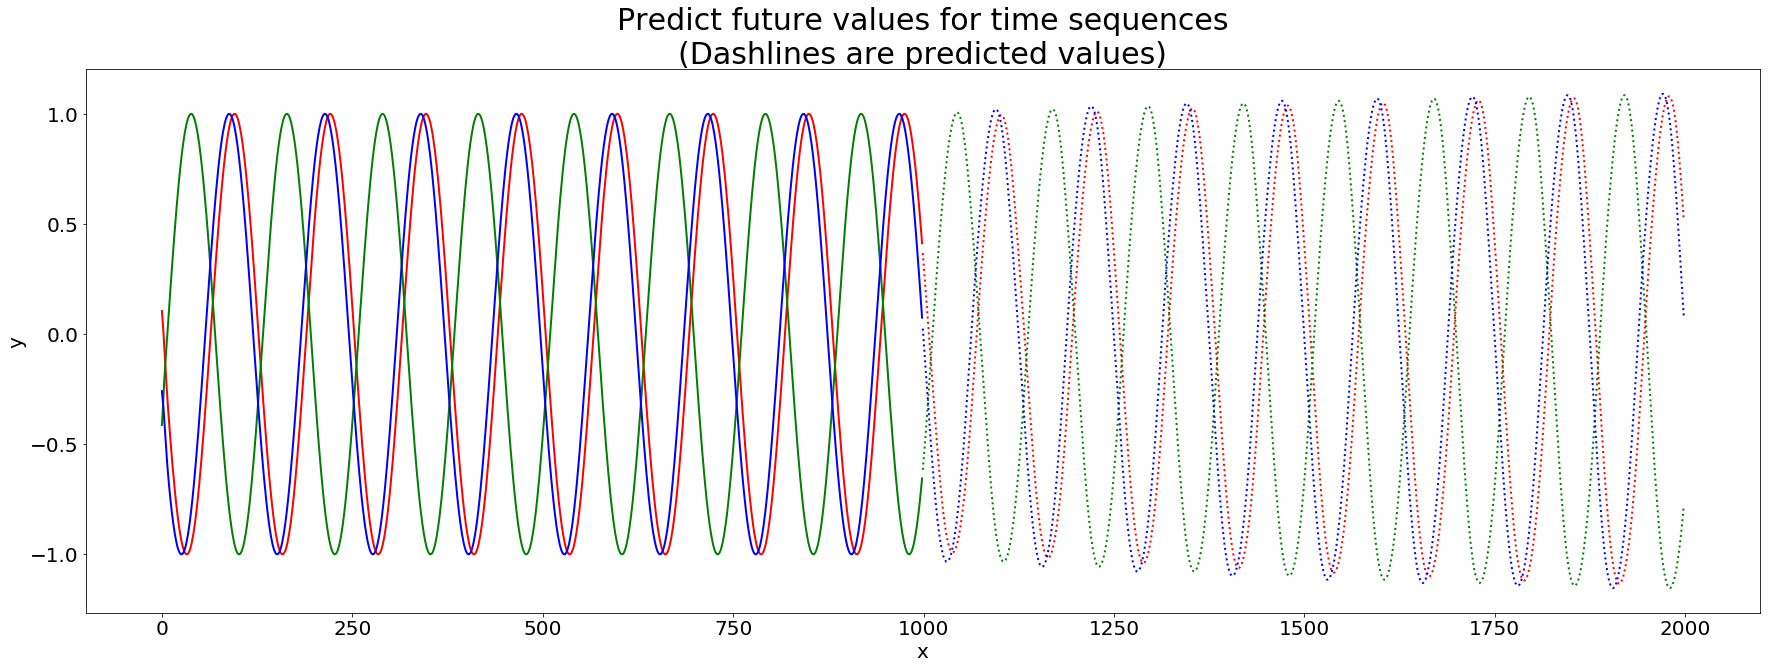

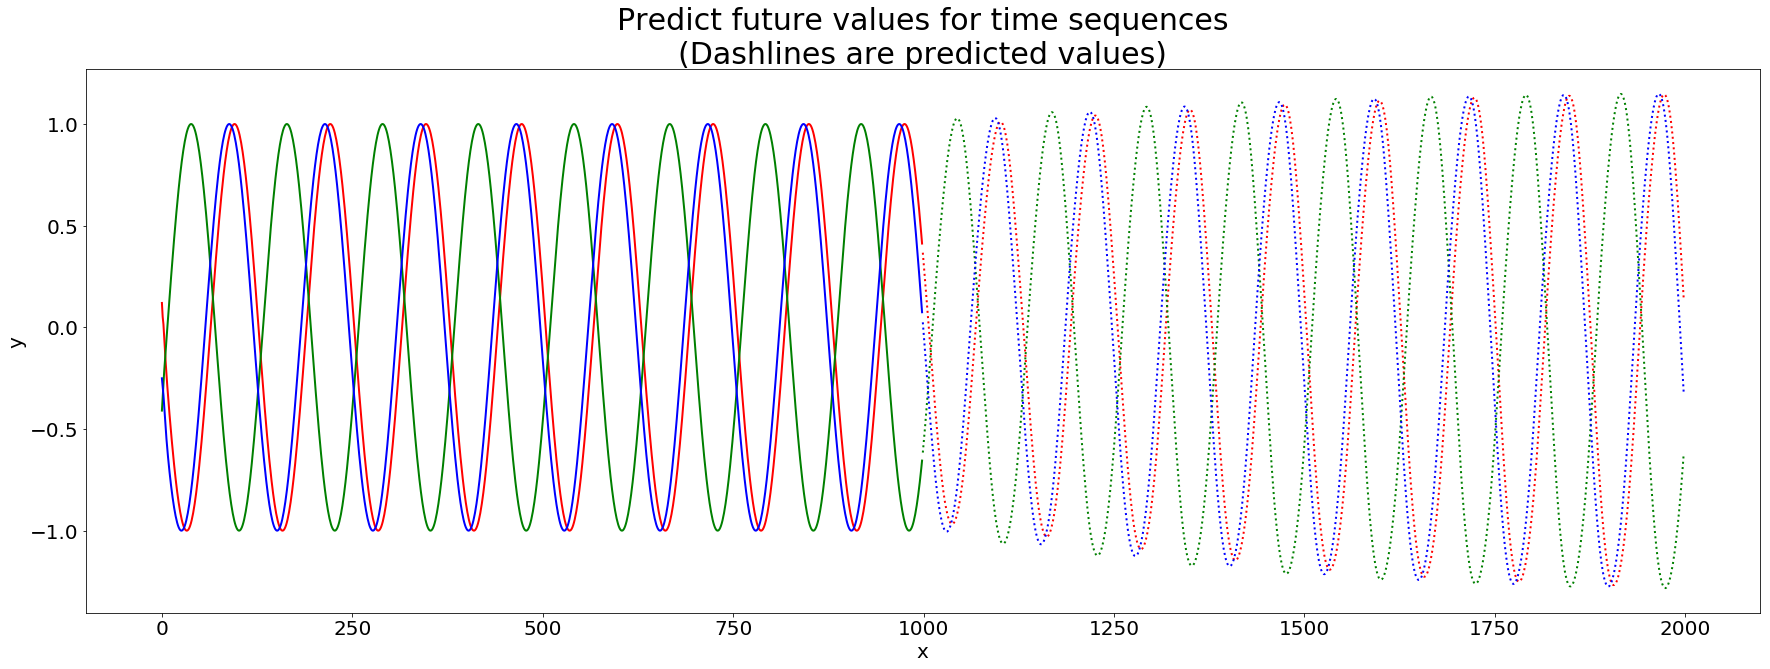

In [39]:
input_size = 1
hidden_size = 20
#model = LSTM(input_size, hidden_size)
model = LSTM(input_size, hidden_size)
model.double()

criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr=0.8)
train()